<a href="https://colab.research.google.com/github/santiagorg2401/tensorflow_course_exercises/blob/main/08_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series fundamentals and Milestone Project 3

Terminology:
* **Horizon** Number of timesteps into the future to predict.
* **Window Size** Number of timesteps used to predict the horizon
* **Seasonality**  Number of samples per year

## Solve importations

In [148]:
import os
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

RANDOM_SEED = 42
BATCH_SIZE = 128
MODEL_PATH = "checkpoints/08_time_series/"

tf.random.set_seed(RANDOM_SEED)
physical_devices = tf.config.list_physical_devices('GPU')
print(f"TensorFlow version: {tf.__version__}")
print(f"Physical GPUs: {physical_devices}")

TensorFlow version: 2.15.0
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Process data

### Import data

In [149]:
# Import time series data using Pandas
try:
  df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                  parse_dates=["Date"],
                  index_col=["Date"])
except:
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
  df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                  parse_dates=["Date"],
                  index_col=["Date"])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [150]:
df.info(), print(f"There are {len(df)} samples.")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB
There are 2787 samples.


(None, None)

Usually ML models needs tons of data to work well, but in this case the historical daily price of BitCoin spans arounf 8 years, around 2787 samples. This is common on Time Series Problems as datasets will not be that large.
The **seasonality** of a time series dataset is referred as the number of samples per year. The seasonality of the BitCoin data is 365 as we have daily BitCoin price data.

<Axes: xlabel='Date'>

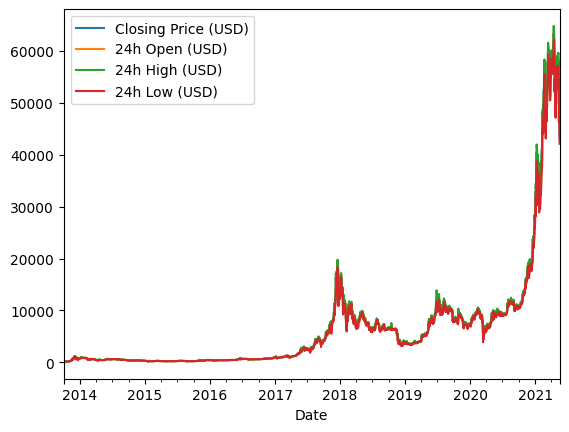

In [151]:
df.plot()

In [152]:
# Use only closing prices
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)" : "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Text(0.5, 1.0, 'BTC Price')

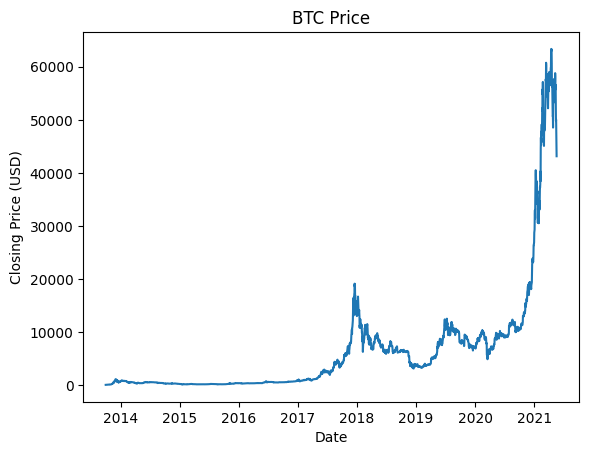

In [153]:
# What about using Python's CSV module?
timesteps = []
btc_price = []

with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  # Skip column titles.
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

plt.plot(timesteps, btc_price)
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.title("BTC Price")

### Create datasets

In [154]:
timesteps = bitcoin_prices.index.to_numpy()
prices =  bitcoin_prices["Price"].to_numpy()

In [155]:
# Create a plotting function
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  plt.plot(timesteps[start:end],values[start:end], format, label=label)
  plt.xlabel("Date")
  plt.ylabel("Closing Price (USD)")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

#### The wrong way
In TimeSeries it is wrong to shuffle the data as we need to predict the future, so the test split must come after the training set.

((2229,), (558,), (2229,), (558,))

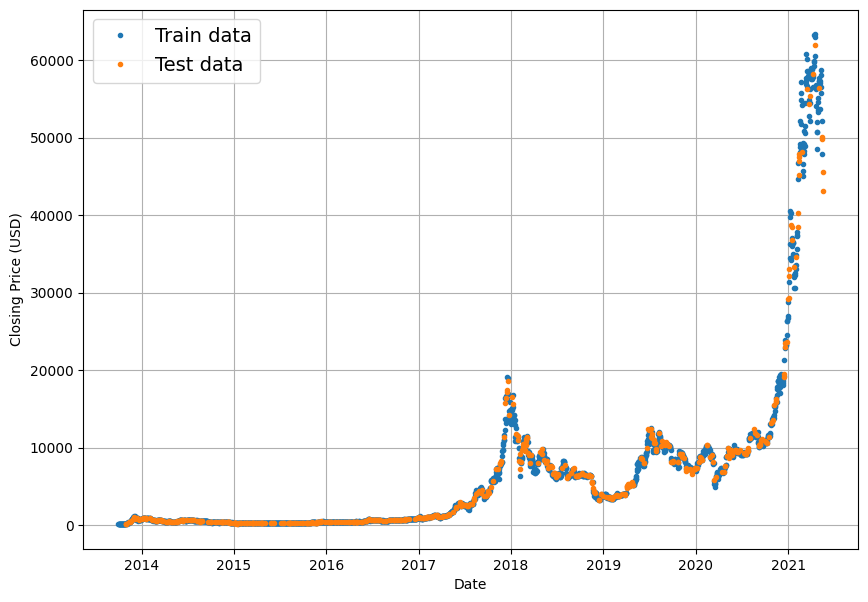

In [156]:
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    train_size=0.8,
                                                    random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

X_train.shape, X_test.shape, y_train.shape, y_test.shape

#### The right way

((2229,), (558,), (2229,), (558,))

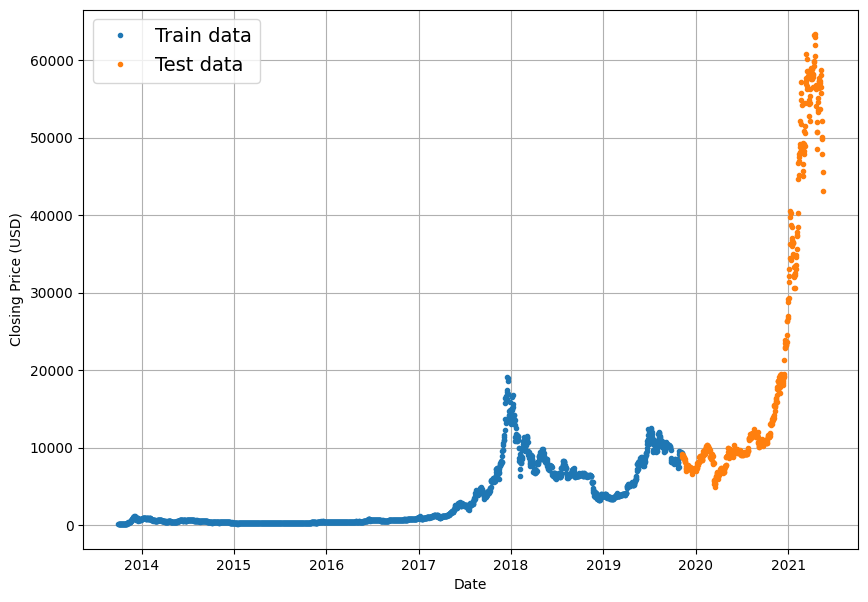

In [157]:
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    train_size=0.8,
                                                    shuffle=False)

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Windowing the datasets
This allows the data to turn into a supervised learning problem.
Windowing for one week

[0, 1, 2, 3, 4, 5, 6] -> [7]

[1, 2, 3, 4, 5, 6, 7] -> [8]

[2, 3, 4, 5, 6, 7, 8] -> [9]

In [158]:
HORIZON = 1; WINDOW_SIZE = 7

def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [159]:
# Test function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8) +1, axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

The previous function only works at a small scale, then we use NumPy indexing because using `for` loops is too slow.

In [160]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows
  of window_size with horizon size labels
  """
  # Create a window of specific window_size and add horizon at the end.
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # Create a 2D array of multiple windows (-1 accounts for 0 indexing).
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T

  # Index on the target array with 2D array of multiple window steps.
  windowed_array = x[window_indexes]

  # Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon)

  return windows, labels

In [161]:
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [162]:
# View the first/last 3 windows & labels
for i in range(3):
  print(f"Window:{full_windows[i]} -> label: {full_labels[i]}")
for i in range(3):
  print(f"Window:{full_windows[i-3]} -> label: {full_labels[i-3]}")

Window:[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> label: [123.033]
Window:[125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> label: [124.049]
Window:[108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> label: [125.96116]
Window:[58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> label: [47885.62525472]
Window:[58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> label: [45604.61575361]
Window:[55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> label: [43144.47129086]


### Turning windows into training and test sets

In [163]:
def make_train_test_splits(windows, labels, test_split=0.2):
  splits_size = int(len(windows) * (1-test_split))
  train_windows = windows[:splits_size]
  train_labels = labels[:splits_size]
  test_windows = windows[splits_size:]
  test_labels = labels[splits_size:]
  return train_windows, test_windows, train_labels, test_labels

In [164]:
train_windows, test_windows, train_labels, test_labels = train_test_split(full_windows,
                                                                          full_labels,
                                                                          test_size=0.2,
                                                                          train_size=0.8,
                                                                          shuffle=False)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [165]:
# Check if labels are equal before and after windowing.
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint
This allows us to comparing the different models fairly

In [166]:
def model_checkpoint(path, model_name, monitor="val_loss"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(path, model_name),
                                            verbose=0,
                                            save_best_only=True,
                                            monitor=monitor)

## `model_0` Naive model (baseline)
$$\hat{y}_{t} = y_{t-1}$$

### Create model

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

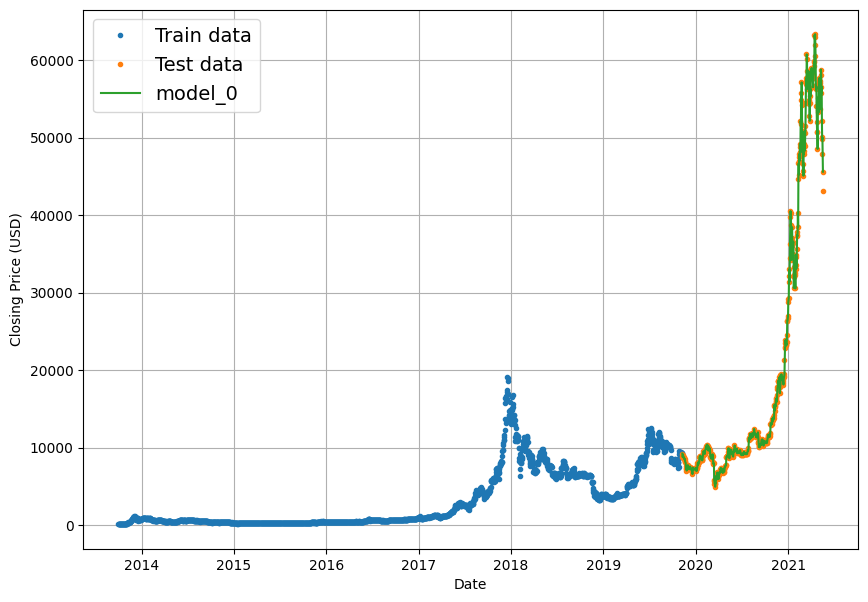

In [167]:
# Create a naive forecast
model_0 = y_test[:-1]

plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")
plot_time_series(X_test[1:], model_0, format="-", label="model_0")

model_0[:10], model_0[-10:]

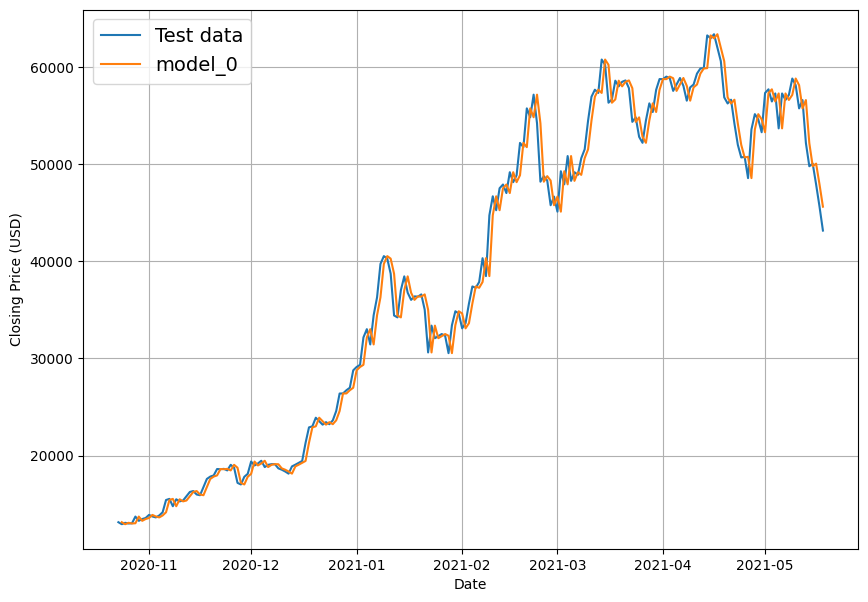

In [168]:
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=model_0, start=350, format="-", label="model_0")

### Evaluate model

In [169]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE assuming no seasonality of data
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  # As out seasonality is 1 then the shift is also 1.
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season

# Create a function to take in model preds and truth values to return evaluation metrics.
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype.
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate the evaluation metrics.
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for horizons greater than 1
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy(),
          "mape":mape.numpy(),
          "mase":mase.numpy()}

In [170]:
model_0_mase = mean_absolute_scaled_error(y_test[1:], model_0).numpy()
model_0_results = evaluate_preds(y_test[1:], model_0)
model_0_mase, model_0_results

(0.9995699939182624,
 {'mae': 567.9802,
  'mse': 1147547.0,
  'rmse': 1071.2362,
  'mape': 2.516525,
  'mase': 0.99957})

## `model_1` Dense model horizon = 1, window = 7

### Create the model

In [171]:
# Create the model.
model_1 = tf.keras.Sequential([layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON, activation="linear")],
                              name="model_1")
# Compile the model.
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# Fit the model.
model_1_history = model_1.fit(train_windows,
                              train_labels,
                              epochs=100,
                              verbose=0,
                              batch_size=BATCH_SIZE,
                              validation_data=(test_windows, test_labels),
                              callbacks=[model_checkpoint(MODEL_PATH, "model_1")])

# Summary.
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               1024      
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Making forecasts
These are not actual forecasts since they are predictions on the future

In [172]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [173]:
model_1 = tf.keras.models.load_model(os.path.join(MODEL_PATH, "model_1"))
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:3]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([8830.439, 8781.419, 9026.457], dtype=float32)>)

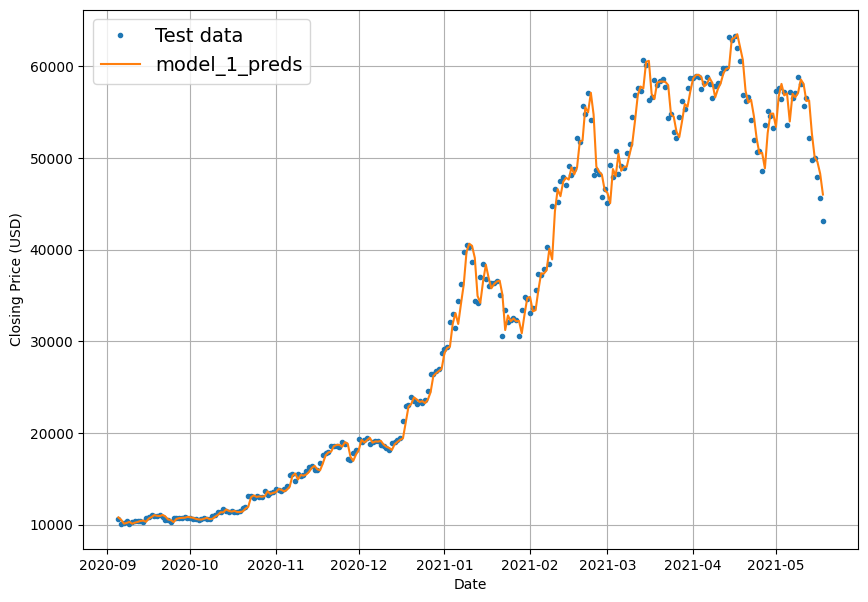

In [174]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(X_test[-len(test_windows):],
                 test_labels[:, 0],
                 start=offset,
                 label="Test data")

plot_time_series(X_test[-len(test_windows):],
                 model_1_preds,
                 start=offset,
                 format="-",
                 label="model_1_preds")

### Evaluate the model

In [175]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 563.7013 - mae: 563.7013 - mse: 1150125.1250


[563.7012939453125, 563.7012939453125, 1150125.125]

In [176]:
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds)
model_1_results

{'mae': 563.7013,
 'mse': 1150125.1,
 'rmse': 1072.4388,
 'mape': 2.5338535,
 'mase': 0.99026704}

## `model_2` from `model_1` horizon = 1, window = 30

### Create the model

In [177]:
HORIZON = 1
WINDOW_SIZE = 30

# Make windowed data witha appropiate horizon and window sizes.
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)

# Make windowed datasets
train_windows, test_windows, train_labels, test_labels = train_test_split(full_windows,
                                                                          full_labels,
                                                                          test_size=0.2,
                                                                          train_size=0.8,
                                                                          shuffle=False)
# Build the model
model_2 = tf.keras.Sequential([layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON, activation="linear")],
                              name="model_2")

# Conmpile the model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=BATCH_SIZE,
            validation_data=(test_windows, test_labels),
            callbacks=[model_checkpoint(MODEL_PATH, "model_2")])

# Summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               3968      
                                                                 
 dense_22 (Dense)            (None, 1)                 129       
                                                                 
Total params: 4097 (16.00 KB)
Trainable params: 4097 (16.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Make forecasts

18/18 [==============================] - 0s 3ms/step


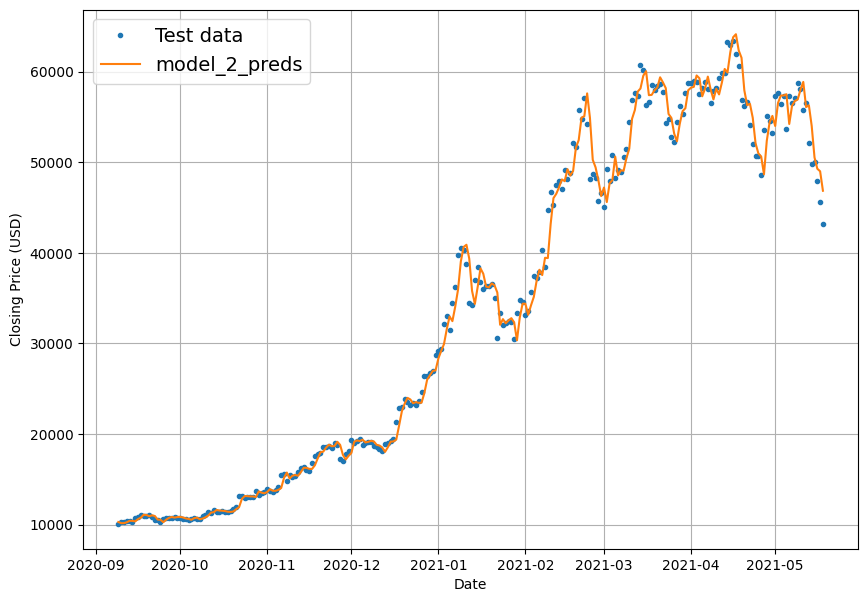

In [178]:
model_2 = tf.keras.models.load_model(os.path.join(MODEL_PATH, "model_2"))
model_2_preds = make_preds(model_2, test_windows)

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(X_test[-len(test_windows):],
                 test_labels[:, 0],
                 start=offset,
                 label="Test data")

plot_time_series(X_test[-len(test_windows):],
                 model_2_preds,
                 start=offset,
                 format="-",
                 label="model_2_preds")

### Evaluate model

In [179]:
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

{'mae': 599.4211,
 'mse': 1243937.1,
 'rmse': 1115.3193,
 'mape': 2.6697035,
 'mase': 1.047794}

## `model_3` from `model_1` horizon = 7, window = 30

### Create the model

In [229]:
HORIZON = 7; WINDOW_SIZE = 30

# Make windowed data
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)

# Make datasets
train_windows, test_windows, train_labels, test_labels = train_test_split(full_windows,
                                                                          full_labels,
                                                                          test_size=0.2,
                                                                          train_size=0.8,
                                                                          shuffle=False)
# Build the model
model_3 = tf.keras.Sequential([layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON, activation="linear")],
                              name="model_3")

# Compile the model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", 'mse'])

# Fit the model
model_3_history = model_3.fit(train_windows,
                              train_labels,
                              epochs=100,
                              validation_data=(test_windows, test_labels),
                              verbose=0,
                              callbacks=[model_checkpoint(MODEL_PATH, "model_3")])

# Summary
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_202 (Dense)           (None, 128)               3968      
                                                                 
 dense_203 (Dense)           (None, 7)                 903       
                                                                 
Total params: 4871 (19.03 KB)
Trainable params: 4871 (19.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Make forecasts

18/18 [==============================] - 0s 2ms/step


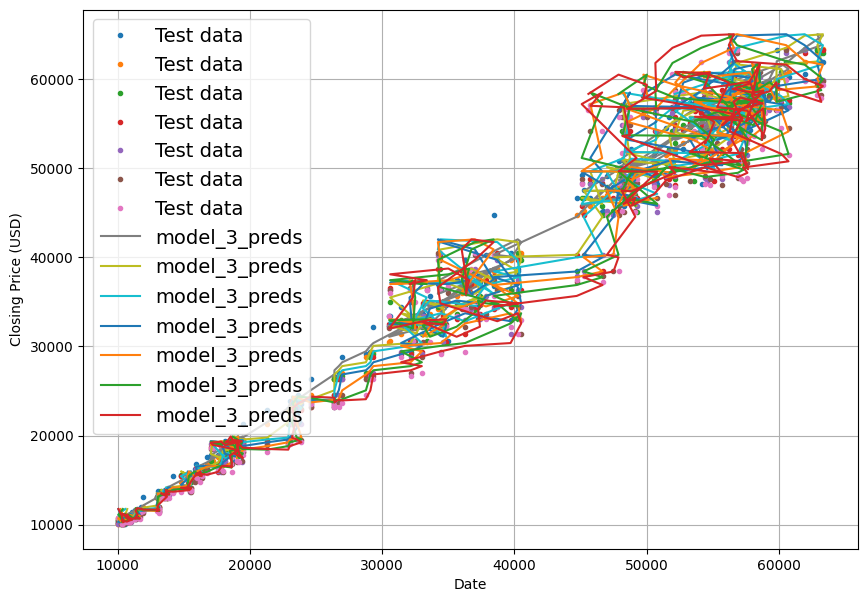

In [230]:
model_3 = tf.keras.models.load_model(os.path.join(MODEL_PATH, "model_3"))
model_3_preds = make_preds(model_3, test_windows)

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(X_test[-len(test_windows):],
                 test_labels[:, 0],
                 start=offset,
                 label="Test data")

plot_time_series(X_test[-len(test_windows):],
                 tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label="model_3_preds")

### Evaluate the model
It is expected for the metrics to be larger as the horizon increases.

In [232]:
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': 1205.9722,
 'mse': 5290927.0,
 'rmse': 1385.921,
 'mape': 5.4766717,
 'mase': 2.14596}

## `model_4` Conv1D
In this case, the shape must be `(batch_size, timesteps, input_dim)`

### Create the model

In [183]:
HORIZON = 1; WINDOW_SIZE = 7
tf.random.set_seed(42)

# Make windowed data
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)

# Make datasets
train_windows, test_windows, train_labels, test_labels = train_test_split(full_windows,
                                                                          full_labels,
                                                                          test_size=0.2,
                                                                          train_size=0.8,
                                                                          shuffle=False)

# Reshape data as (batch_size, timesteps, input_dim) using a Lambda layer
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

# Build the model
model_4 = tf.keras.Sequential([expand_dims_layer,
                               layers.Conv1D(128, WINDOW_SIZE, padding="causal"),
                               layers.Dense(HORIZON, activation="relu")],
                              name="model_4")

# Compile the model
model_4.compile(loss=["mae"],
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# Fit the model
model_4_history = model_4.fit(train_windows,
                              train_labels,
                              batch_size=128,
                              epochs=100,
                              verbose=0,
                              validation_data=(test_windows, test_labels),
                              callbacks=[model_checkpoint(MODEL_PATH, "model_4")])

# Summamry
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            6400      
                                                                 
 dense_25 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 6529 (25.50 KB)
Trainable params: 6529 (25.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Make forecasts

18/18 [==============================] - 0s 5ms/step


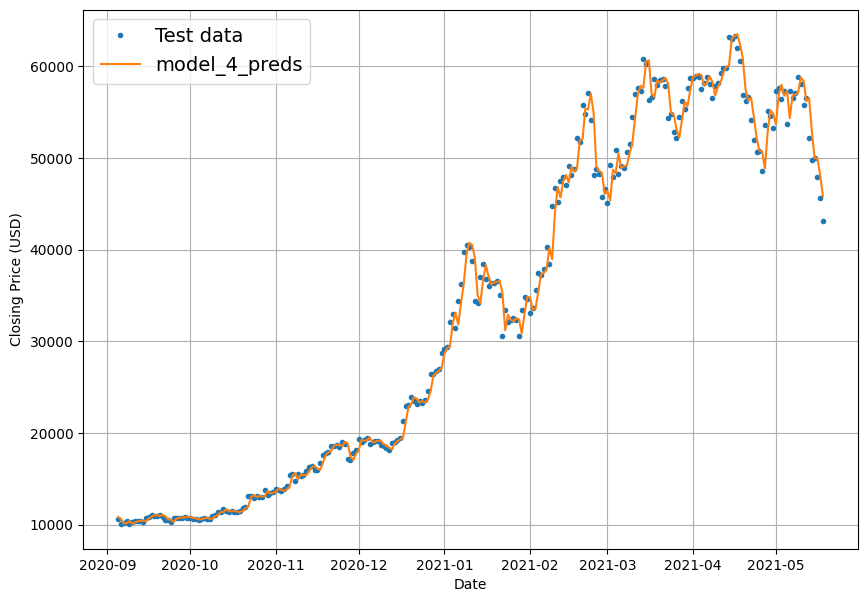

In [184]:
model_4 = tf.keras.models.load_model(os.path.join(MODEL_PATH, "model_4"))
model_4_preds = make_preds(model_4, test_windows)

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(X_test[-len(test_windows):],
                 test_labels[:, 0],
                 start=offset,
                 label="Test data")

plot_time_series(X_test[-len(test_windows):],
                 model_4_preds,
                 start=offset,
                 format="-",
                 label="model_4_preds")

### Evaluate the model

In [185]:
model_4_results = evaluate_preds(tf.squeeze(test_labels), model_4_preds)
model_4_results

{'mae': 564.7306,
 'mse': 1157561.5,
 'rmse': 1075.9003,
 'mape': 2.511829,
 'mase': 0.9920752}

## `model_5` LSTM

### Create the model

In [186]:
tf.random.set_seed(42)

# Build the model
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5")

# Compile the model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# Fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[model_checkpoint(MODEL_PATH, "model_5")])

model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense_26 (Dense)            (None, 1)                 129       
                                                                 
Total params: 69761 (272.50 KB)
Trainable params: 69761 (272.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Make forecasts

18/18 [==============================] - 0s 2ms/step


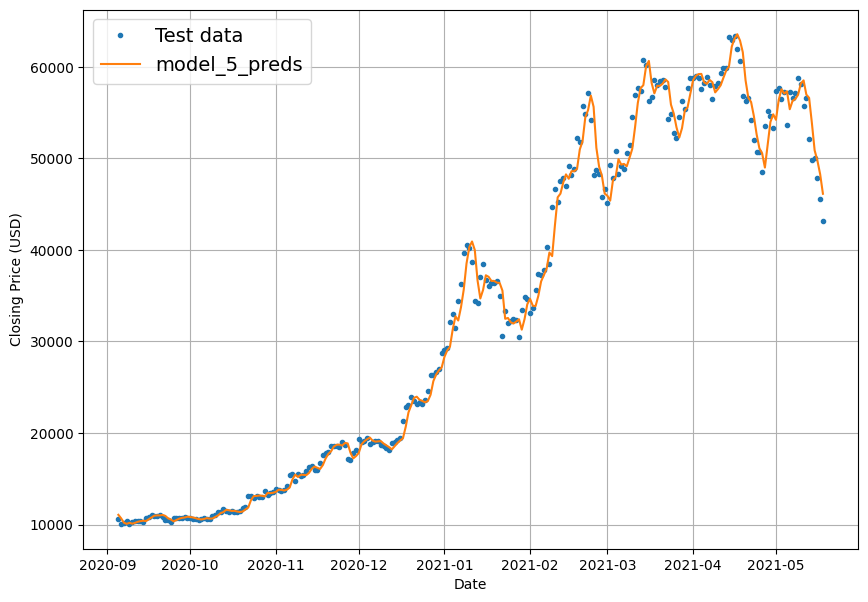

In [187]:
model_5 = tf.keras.models.load_model(os.path.join(MODEL_PATH, "model_5"))
model_5_preds = make_preds(model_5, test_windows)

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(X_test[-len(test_windows):],
                 test_labels[:, 0],
                 start=offset,
                 label="Test data")

plot_time_series(X_test[-len(test_windows):],
                 model_5_preds,
                 start=offset,
                 format="-",
                 label="model_5_preds")

### Evaluate the model

In [188]:
model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)
model_5_results

{'mae': 612.67255,
 'mse': 1317640.0,
 'rmse': 1147.885,
 'mape': 2.7459307,
 'mase': 1.076296}

## Make a multivariate time series dataset

In [189]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


<Axes: xlabel='Date'>

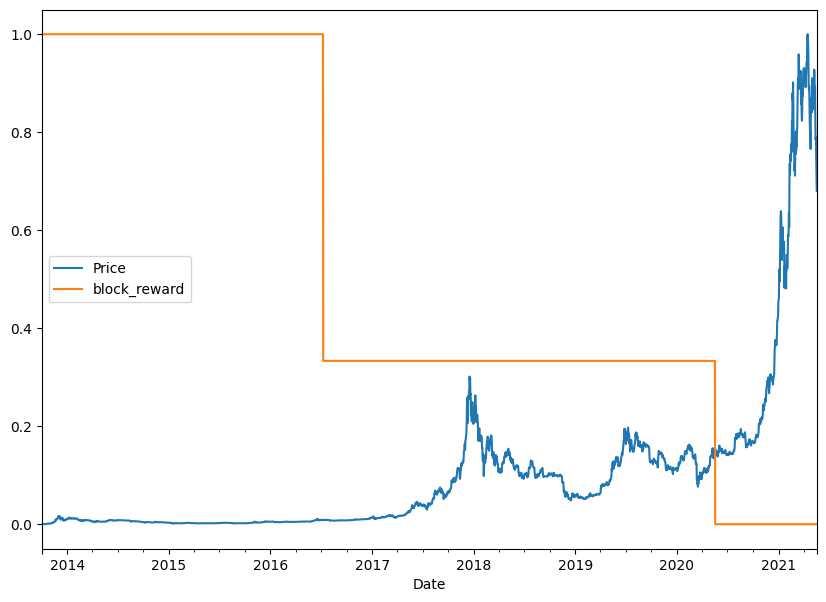

In [190]:
# Bitcoin halving affect Bitcoin price, add them to the dataset
block_reward_1 = 50 # January 3 2009
block_reward_2 = 25 # November 8 2012
block_reward_3 = 12.5 # July 9 2016
block_reward_4 = 6.25 # May 19 2020

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:,-1] = block_reward_4

# Adjust data scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                  columns=bitcoin_prices_block.columns,
                                                  index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7))

## Making a windowed dataset with pandas

In [191]:
HORIZON = 1; WINDOW_SIZE = 7

bitcoin_prices_windowed = bitcoin_prices_block.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(8)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499


In [192]:
# Remove all rows containing a NaN value
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [193]:
# Make train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.2,
                                                      shuffle=False)

## `model_6` from `model_1` with multivariate data

### Create the model

In [194]:
tf.random.set_seed(42)

# Build the model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6")

# Compile the model
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="mae")

# Fit the model
model_6_history = model_6.fit(X_train, y_train,
                              epochs=100,
                              batch_size=128,
                              verbose=0,
                              validation_data=(X_test, y_test),
                              callbacks=[model_checkpoint(MODEL_PATH, "model_6")])

model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 128)               1152      
                                                                 
 dense_28 (Dense)            (None, 128)               16512     
                                                                 
 dense_29 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17793 (69.50 KB)
Trainable params: 17793 (69.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Make forecasts

In [195]:
model_6 = tf.keras.models.load_model(os.path.join(MODEL_PATH, "model_6"))
model_6_preds = tf.squeeze(model_6.predict(X_test))

18/18 [==============================] - 0s 2ms/step


### Evaluate the model

In [196]:
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

{'mae': 565.8437,
 'mse': 1151285.1,
 'rmse': 1072.9795,
 'mape': 2.5601323,
 'mase': 0.99403065}

## `model_7` N-BEATS Algorithm

### Create the model

In [197]:
# Build the N-BEATS model
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):

    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # First block of fully connected layers, theta backcast and forecast.
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)

    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Test the NBeats block layer with dummy data

In [198]:
tf.random.set_seed(42)
dummy_nbeats = NBeatsBlock(input_size=WINDOW_SIZE,
                           theta_size=WINDOW_SIZE+HORIZON,
                           horizon=HORIZON,
                           n_neurons=128,
                           n_layers=4)

dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)

backcast, forecast = dummy_nbeats(dummy_inputs)
print(f"Backacast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backacast: [ 0.32873127  0.4039675   0.14610271  0.27949154 -0.08193181 -0.16378495
  0.00741839]
Forecast: 0.5074476003646851


### Prepare dataset

In [199]:
HORIZON = 1; WINDOW_SIZE  = 7; BATCH_SIZE = 1024
bitcoin_prices_nbeats = bitcoin_prices.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)

# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size= 0.2,
                                                    shuffle=False)
# Use the tf.data API to improve performance
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Fit the model

In [200]:
# Setting up hyperparameters for N-Beats
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON
BATCH_SIZE = 1024

# Instance an NBeatsBlock and an initial stack
n_beats_l = NBeatsBlock(input_size=INPUT_SIZE,
                        theta_size=THETA_SIZE,
                        horizon=HORIZON,
                        n_neurons=N_NEURONS,
                        n_layers=N_LAYERS,
                        name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")
residuals, forecast = n_beats_l(stack_input)

# Create stack blocks
for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                         theta_size=THETA_SIZE,
                                         horizon=HORIZON,
                                         n_neurons=N_NEURONS,
                                         n_layers=N_LAYERS,
                                         name=f"NBeatsBlock_{i}")(residuals)
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7")

model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="mae")

model_7_history = model_7.fit(train_dataset,
                              epochs=N_EPOCHS,
                              validation_data=test_dataset,
                              verbose=0,
                              callbacks=[model_checkpoint(MODEL_PATH, "model_7"),
                                         tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                          patience=200,
                                                                          restore_best_weights=True),
                                         tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                              patience=100,
                                                                              verbose=1)])
model_7.summary()


Epoch 1060: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1160: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 stack_input (InputLayer)    [(None, 7)]                  0         []                            
                                                                                                  
 InitialBlock (NBeatsBlock)  ((None, 7),                  796168    ['stack_input[0][0]']         
                              (None, 1))                                                          
                                                                                                  
 NBeatsBlock_0 (NBeatsBlock  ((None, 7),                  796168    ['InitialBlock[0][0]']        
 )                           

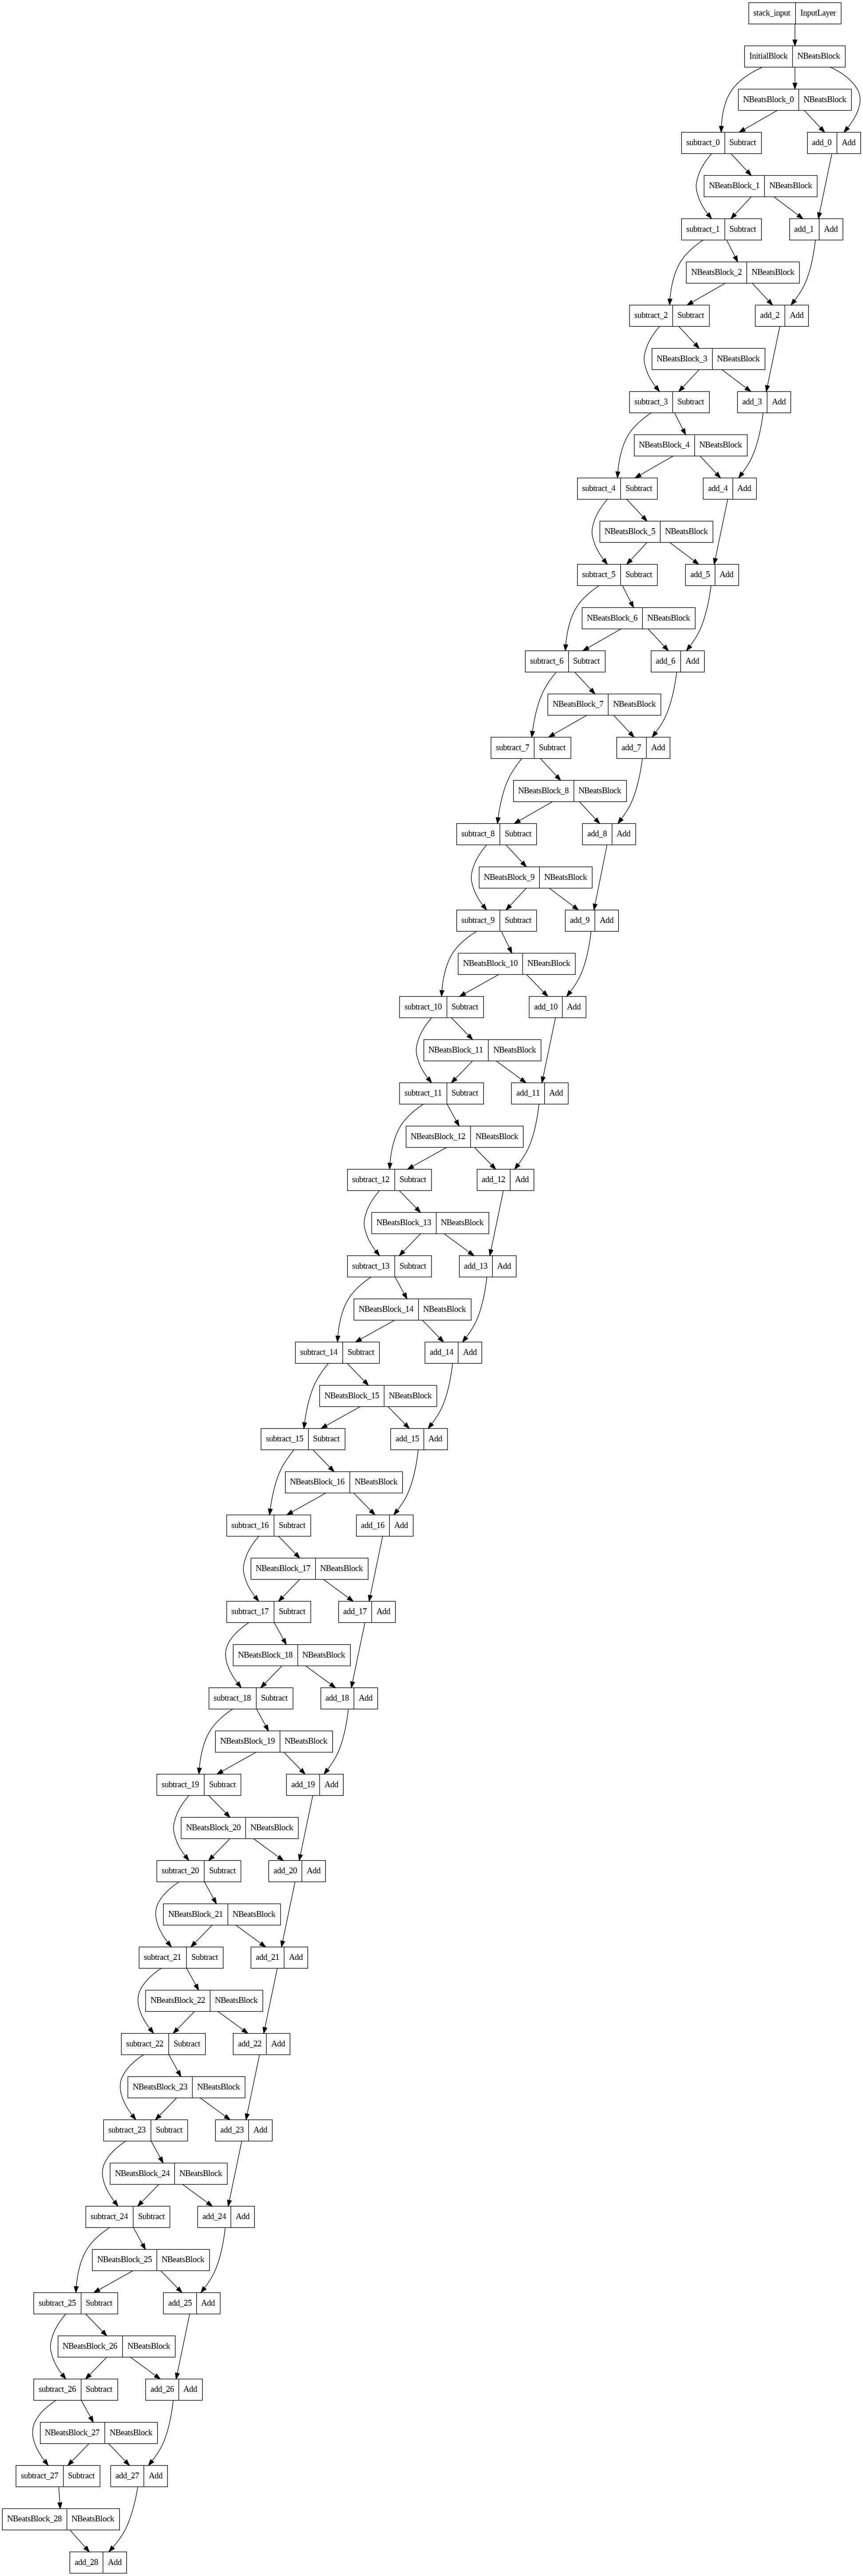

In [201]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

### Make forecasts

In [202]:
model_7 = tf.keras.models.load_model(os.path.join(MODEL_PATH, "model_7"))
model_7_preds = make_preds(model_7, X_test)

18/18 [==============================] - 1s 10ms/step


### Evaluate the model

In [203]:
model_7_results = evaluate_preds(y_test, model_7_preds)
model_7_results

{'mae': 568.257,
 'mse': 1169131.2,
 'rmse': 1081.2637,
 'mape': 2.573979,
 'mase': 0.9982702}

## `model_8` Ensemble (multiple mdels stacked together)

### Create the model

In [204]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  ensemble_models = []

  for i in range(num_iter):
    for loss_function in loss_fns:
      print(f"Optimizing model by minimizing: {loss_function} for {num_epochs} epochs. Model number: {i}.")
      model = tf.keras.Sequential([
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(horizon)
      ])
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      model.fit(train_dataset,
                epochs=num_epochs,
                validation_data=test_dataset,
                verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=200,
                                                  restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      ensemble_models.append(model)
  return ensemble_models

In [205]:
%%time
ensemble_models = get_ensemble_models(num_iter=5)

Optimizing model by minimizing: mae for 1000 epochs. Model number: 0.

Epoch 854: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 954: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by minimizing: mse for 1000 epochs. Model number: 0.

Epoch 348: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 448: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by minimizing: mape for 1000 epochs. Model number: 0.

Epoch 170: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 560: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 673: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 773: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Optimizing model by minimizing: mae for 1000 epochs. Model number: 1.
Optimizing model by minimizing: mse for 1000 epochs. Model number: 1.

Epoch 24

### Make forecasts

In [206]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds=[]
  for model in ensemble_models:
    ensemble_preds.append(model.predict(data))
  return tf.constant(tf.squeeze(ensemble_preds))

In [207]:
%%time
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)
ensemble_preds

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 65ms/step
CPU times: user 1.01 s, sys: 29.7 ms, total: 1.04 s
Wall time: 1.16 s


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8822.258 ,  8775.784 ,  9103.798 , ..., 50361.72  , 48770.49  ,
        45470.54  ],
       [ 8784.649 ,  8763.523 ,  8991.492 , ..., 50336.324 , 48216.715 ,
        46207.703 ],
       [ 8779.427 ,  8757.547 ,  9113.258 , ..., 49462.293 , 48210.49  ,
        46472.12  ],
       ...,
       [ 8682.887 ,  8698.974 ,  9002.109 , ..., 49583.16  , 48093.742 ,
        45648.766 ],
       [ 8832.531 ,  8746.239 ,  9069.385 , ..., 50000.836 , 48634.293 ,
        45777.56  ],
       [ 8787.562 ,  8800.555 ,  9102.5205, ..., 50081.027 , 48204.48  ,
        45855.47  ]], dtype=float32)>

### Evaluate the model

In [208]:
model_8_results = evaluate_preds(y_test, ensemble_preds)
model_8_results

{'mae': 579.3829,
 'mse': 1178650.9,
 'rmse': 1085.5846,
 'mape': 2.645345,
 'mase': 1.0178152}

In [209]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
model_8_results = evaluate_preds(y_test, ensemble_mean)
model_8_results

{'mae': 566.8519,
 'mse': 1143570.0,
 'rmse': 1069.3783,
 'mape': 2.5721362,
 'mase': 0.9958018}

### Make prediction interval

In [210]:
def get_upper_lower(preds):
  std = tf.math.reduce_std(preds, axis=0)
  interval = 1.96 * std

  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

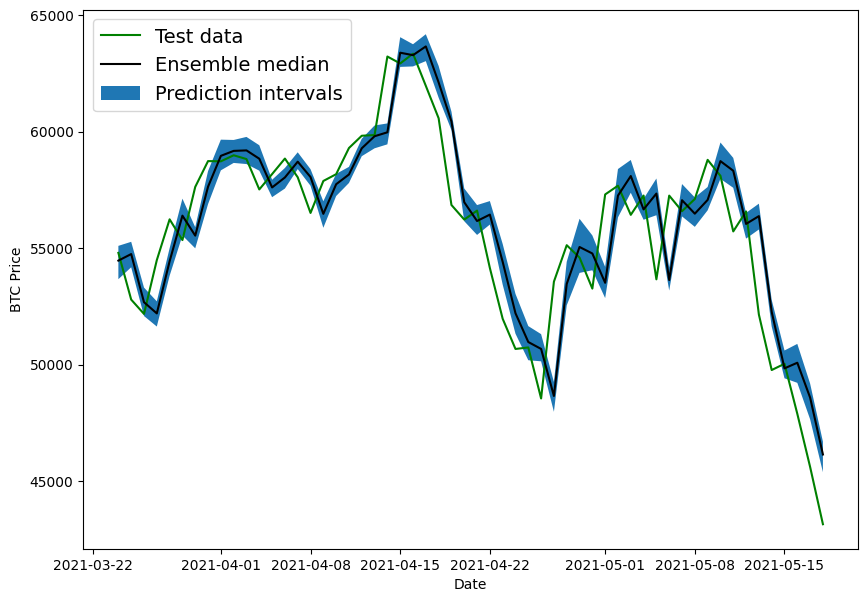

In [211]:
lower, upper = get_upper_lower(preds=ensemble_preds)
ensemble_median = np.median(ensemble_preds, axis=0)

offset=500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction intervals")
plt.legend(loc="upper left", fontsize=14)

## `model_9` Future prediction model
Use **all** of the BTC dataset to train a model and predict the future

### Prepare dataset

In [212]:
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all,  labels_dataset_all))

BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Create the model

In [213]:
tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
])

model_9.compile(loss=tf.keras.losses.mae,
                 optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs=100,
            verbose=0,
            callbacks=[model_checkpoint(MODEL_PATH, "model_9", "loss")])

model_9.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_199 (Dense)           (None, 128)               1024      
                                                                 
 dense_200 (Dense)           (None, 128)               16512     
                                                                 
 dense_201 (Dense)           (None, 1)                 129       
                                                                 
Total params: 17665 (69.00 KB)
Trainable params: 17665 (69.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Make forecasts

In [214]:
# How many time steps into the future?
INTO_FUTURE = 14

# Create a future prediction function
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-window_size:]

  for _ in range(into_future):
    # Predict on the last window and append
    pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"\nWindow: {last_window} -> Prediction: {pred}")
    future_forecast.append(tf.squeeze(pred).numpy())
    last_window = np.append(last_window, pred)[-window_size:]

  return future_forecast

In [215]:
future_forecast = make_future_forecasts(values=y_all,
                      model=model_9,
                      into_future=INTO_FUTURE)

1/1 [==============================] - 0s 83ms/step

Window: [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: [[56012.5]]
1/1 [==============================] - 0s 32ms/step

Window: [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 56012.5       ] -> Prediction: [[49958.535]]
1/1 [==============================] - 0s 30ms/step

Window: [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 56012.5        49958.53515625] -> Prediction: [[50146.848]]
1/1 [==============================] - 0s 30ms/step

Window: [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 56012.5        49958.53515625 50146.84765625] -> Prediction: [[50054.754]]
1/1 [==============================] - 0s 37ms/step

Window: [47885.62525472 45604.61575361 43144.47129086 56012.5
 49958.53515625 50146.84765625 50054.75390625] -> Prediction: [[46249.242]]
1/1 [==============

### Plot future model
Since we cannot evaluate future data points until it actually happens, try to evaluate using a plot

In [216]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")

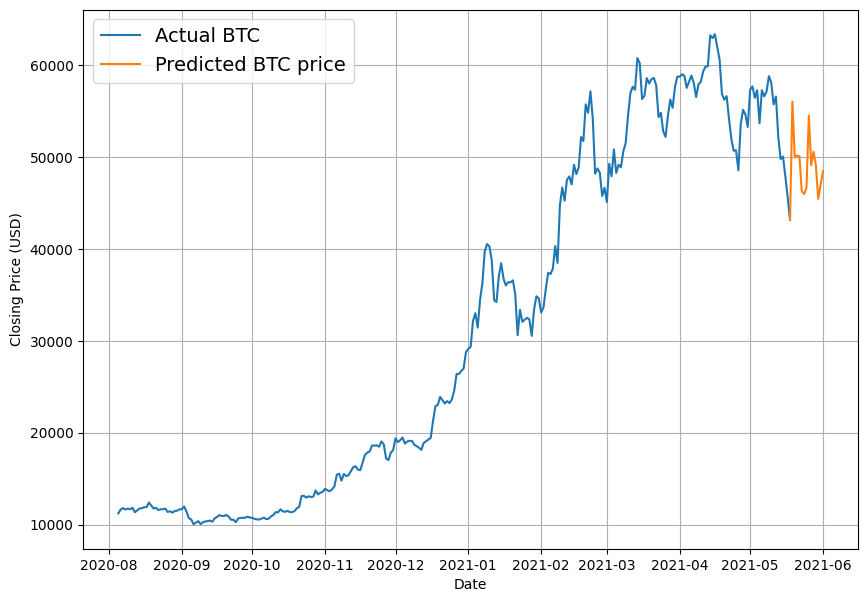

In [217]:
last_timestep = bitcoin_prices.index[-1]
future_dates = get_future_dates(start_date=last_timestep,
                                into_future=INTO_FUTURE)

# Insert last data point into future so we can avoid the graph looking disconnected
future_dates = np.insert(future_dates, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])

# Plot BTC graphs
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC")
plot_time_series(future_dates, future_forecast, format="-", label="Predicted BTC price")

## `model_10` from `model_1` with turkey data

### Create turkey data aka highly improbable data



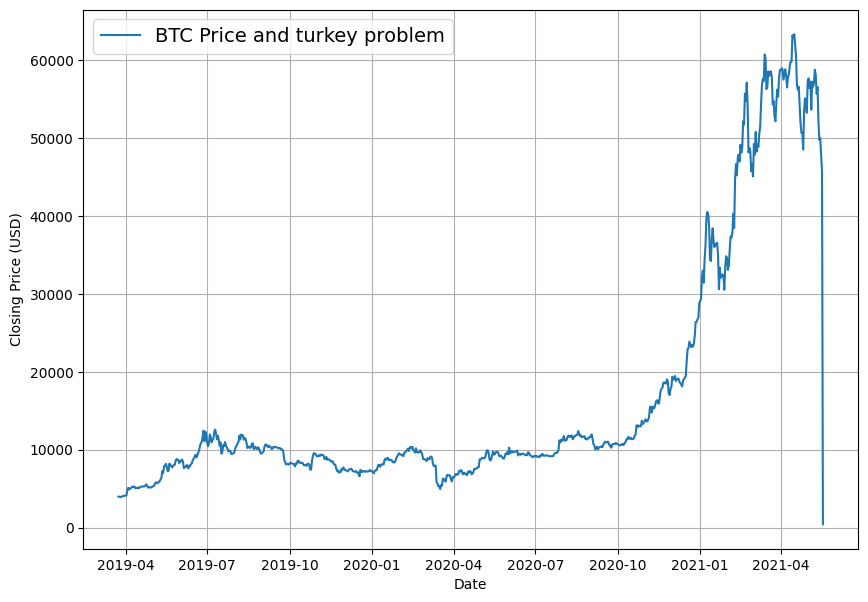

In [218]:
# Create the turjey data and artificially alter the last data point
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] /= 100

btc_timesteps_turkey = np.array(bitcoin_prices.index)

# Create turkey datasets
WINDOW_SIZE = 7; HORIZON = 1
full_windows, full_labels = make_windows(np.array(btc_price_turkey),
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)

X_train, X_test, y_train, y_test = train_test_split(full_windows,
                                                    full_labels,
                                                    test_size=0.2,
                                                    shuffle=False)

X_train_ds  = tf.data.Dataset.from_tensor_slices(X_train)
y_train_ds = tf.data.Dataset.from_tensor_slices(y_train)
turkey_train_ds = tf.data.Dataset.zip((X_train_ds, y_train_ds))
turkey_train_ds = turkey_train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Plot turkey data
plt.figure(figsize=(10,7))
plot_time_series(btc_timesteps_turkey,
                 btc_price_turkey,
                 start=2000,
                 format="-",
                 label="BTC Price and turkey problem")

### Create the model

In [219]:
model_10 = tf.keras.models.clone_model(model_1)
model_10.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam())
model_10.fit(turkey_train_ds,
             epochs=100,
             verbose=0,
             validation_data=(X_test, y_test),
             callbacks=[model_checkpoint(MODEL_PATH, "model_10")])
model_10.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               1024      
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Make forecasts
A model CANNOT predict anything that hasn't happened before

18/18 [==============================] - 0s 2ms/step


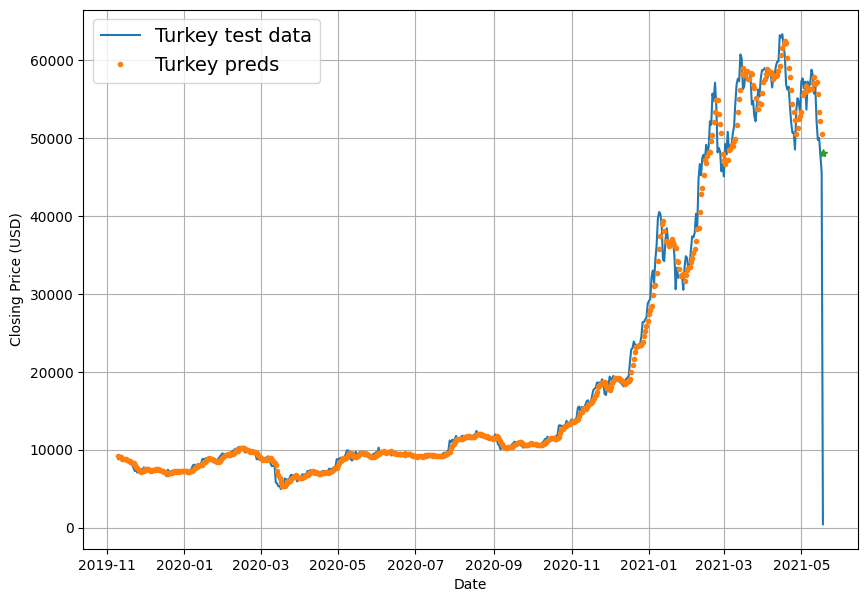

In [220]:
model_10 = tf.keras.models.load_model(os.path.join(MODEL_PATH, "model_10"))
model_10_preds = model_10.predict(X_test)
offset=0
plt.figure(figsize=(10,7))
plot_time_series(btc_timesteps_turkey[-len(X_test):],
                 btc_price_turkey[-len(X_test):],
                 format="-",
                 start=offset,
                 label="Turkey test data")
plot_time_series(btc_timesteps_turkey[-len(X_test):],
                 model_10_preds,
                 start=offset,
                 label="Turkey preds")
plot_time_series([btc_timesteps_turkey[-1]],
                 [model_10_preds[-1]],
                 format="*")

### Fit the model

In [221]:
model_10_results = evaluate_preds(y_test, model_10_preds)
model_10_results

{'mae': 898.5283,
 'mse': 6246940.0,
 'rmse': 898.5283,
 'mape': 23.484848,
 'mase': 1.3904755}

## Compare the models

<Axes: >

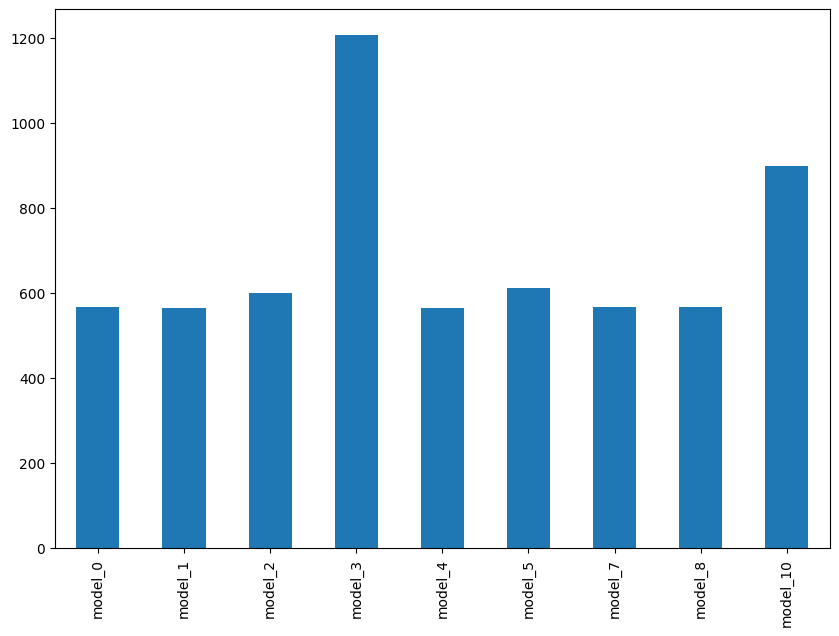

In [233]:
model_results = pd.DataFrame({"model_0": model_0_results,
              "model_1": model_1_results,
              "model_2": model_2_results,
              "model_3": model_3_results,
              "model_4": model_4_results,
              "model_5": model_5_results,
              "model_7": model_7_results,
              "model_8": model_8_results,
              "model_10": model_10_results}).transpose()

model_results["mae"].plot(figsize=(10,7), kind="bar")